### 0. Imports and setup

In [1]:
from src.dataset import Colored3DMNIST, DataLoader
from torchvision import transforms, datasets
from IPython.display import clear_output
from matplotlib.colors import to_hex
from src.nn import UNet, ResNet_D
from src.plot import plot_img
from pathlib import Path
from tqdm import tqdm


import torch.nn.functional as F
import matplotlib.pyplot as plt
import src.data as data
import torch.nn as nn
import numpy as np
import torchvision
import torch
import gc

In [2]:
if torch.cuda.is_available():
    torch.cuda.set_device(f"cuda:0")
torch.manual_seed(42)
np.random.seed(42)

### 1. Getting the data ready

In [3]:
BATCH_SIZE = 16

def random_color(im):
    hue = np.random.choice([60, 120, 240, 280])
    d = (im *(hue%60)/60)
    im_min, im_inc, im_dec = torch.zeros_like(im), d, im - d
    c_im = torch.zeros((3, im.shape[1], im.shape[2]))
    H = round(hue/60) % 6    
    cmap = [[0, 3, 2], [2, 0, 3], [1, 0, 3], [1, 2, 0], [3, 1, 0], [0, 1, 2]]
    return torch.cat((im, im_min, im_dec, im_inc), dim=0)[cmap[H]]

def Add_dimension(im):
    img_3D = torch.zeros(im.shape[0], im.shape[1], im.shape[2], 16)
    for i in range(im.shape[1]):
      if i < 5 or i > 10:
        img_3D[:, :, :, i] = torch.zeros_like(im)
      else:
        img_3D[:, :, :, i] = im
    return img_3D 

def binarize(im):
    return (im > im.max() / 2).to(im.dtype)

TRANSFORM_3D = transforms.Compose([
    transforms.Resize(16),
    transforms.ToTensor(),
    # binarize,
    # random_color,
    Add_dimension,
])

# Load train datasets
mnist_train_a = datasets.MNIST(root='./data', train=True, download=True, transform=TRANSFORM_3D)

indices = mnist_train_a.targets == 3
mnist_train_a.data, mnist_train_a.targets = mnist_train_a.data[indices], mnist_train_a.targets[indices]

mnist_loader_a = torch.utils.data.DataLoader(mnist_train_a, batch_size=BATCH_SIZE, shuffle=True)


mnist_train_b = datasets.MNIST(root='./data', train=True, download=True, transform=TRANSFORM_3D)

indices = mnist_train_b.targets == 5
mnist_train_b.data, mnist_train_b.targets = mnist_train_b.data[indices], mnist_train_b.targets[indices]

mnist_loader_b = torch.utils.data.DataLoader(mnist_train_b, batch_size=BATCH_SIZE, shuffle=True)


mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=TRANSFORM_3D)

indices = mnist_test.targets == 3
mnist_test.data, mnist_test.targets = mnist_test.data[indices], mnist_test.targets[indices]

mnist_loader_test = torch.utils.data.DataLoader(mnist_test, batch_size=BATCH_SIZE, shuffle=True)

Let's plot a number:

In [4]:
next(iter(mnist_loader_a))[0][0].shape

torch.Size([1, 16, 16, 16])

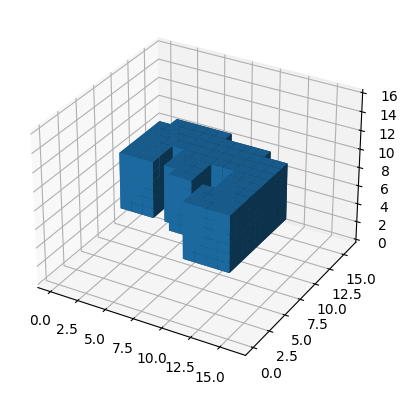

In [5]:
def plot_img(img):
    fig = plt.figure()
    ax = plt.axes(projection="3d")
    
    ax.voxels(img[0])
    plt.show()

plot_img(next(iter(mnist_loader_a))[0][0])

### 3. Preparation for the training

In [6]:
# Taken from https://github.com/iamalexkorotin/NeuralOptimalTransport/blob/main/src/tools.py
def weights_init_D(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
    elif classname.find('BatchNorm') != -1:
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
        
def weights_init_mlp(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')

In [7]:
f = ResNet_D(16, nc=1).cuda()
f.apply(weights_init_D)

T = UNet(1, 1).cuda()

In [8]:
iter_train_a = iter(mnist_loader_a)
iter_train_b = iter(mnist_loader_b)
iter_test = iter(mnist_loader_test)

def sample_train_a():
    global mnist_loader_a, iter_train_a
    try:
        return next(iter_train_a)[0]
    except StopIteration:
        iter_train_a = iter(mnist_loader_a)
        return next(iter_train_a)[0]

def sample_train_b():
    global mnist_loader_b, iter_train_b
    try:
        return next(iter_train_b)[0]
    except StopIteration:
        iter_train_b = iter(mnist_loader_b)
        return next(iter_train_b)[0]

def sample_test():
    global mnist_loader_test, iter_test
    try:
        return next(iter_test)[0]
    except StopIteration:
        iter_test = iter(mnist_loader_test)
        return next(iter_test)[0]

In [9]:
T_opt = torch.optim.Adam(T.parameters(), lr=1e-5, weight_decay=1e-10)
f_opt = torch.optim.Adam(f.parameters(), lr=1e-4, weight_decay=1e-10)

### 4. Training loop

In [10]:
def sq_cost(X, Y):
  return (X-Y).square().flatten(start_dim=1).mean(dim=1)

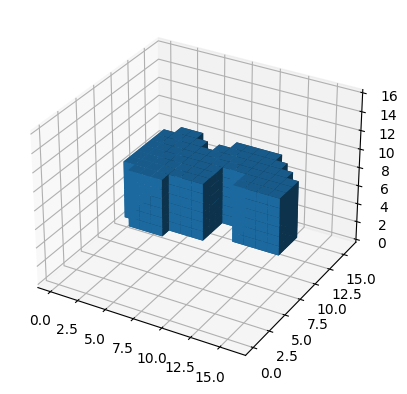

  0%|          | 0/5001 [00:00<?, ?it/s]

T_loss: 0.0826309472322464;  f_loss: -0.0009300727397203445


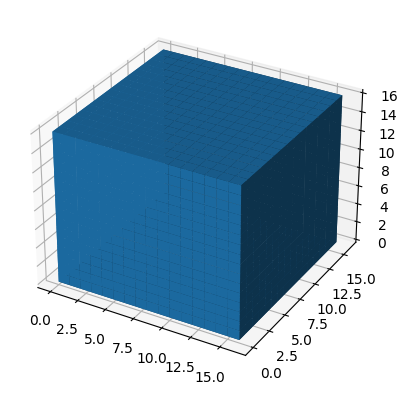

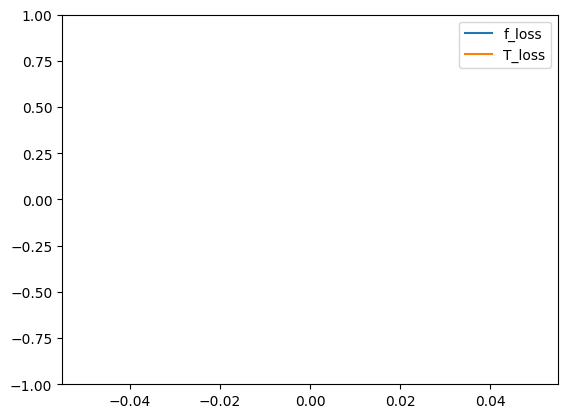

  2%|▏         | 100/5001 [00:47<39:20,  2.08it/s]

T_loss: 0.16554826498031616;  f_loss: -0.009561583399772644


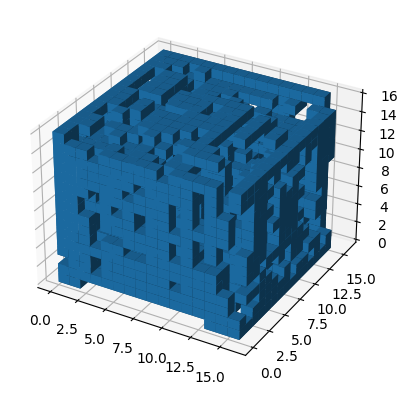

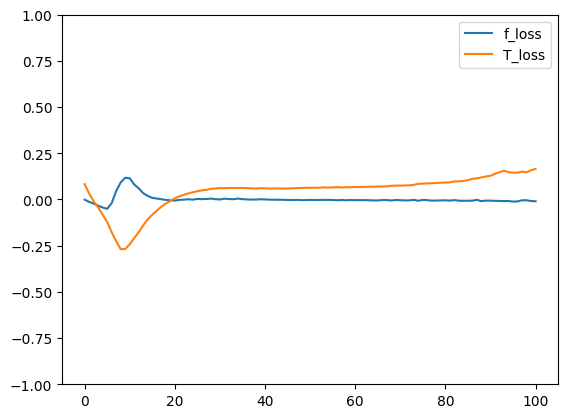

  4%|▍         | 200/5001 [01:34<33:06,  2.42it/s]  

T_loss: 0.4712095260620117;  f_loss: -0.008332550525665283


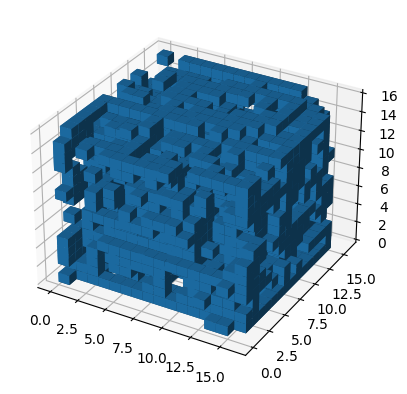

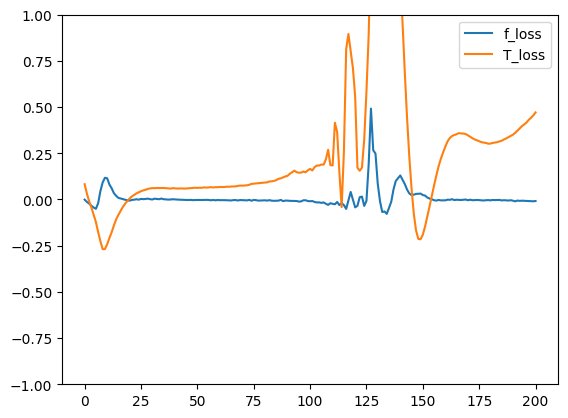

  6%|▌         | 300/5001 [02:19<32:32,  2.41it/s]  

T_loss: 0.2632274627685547;  f_loss: 0.008418023586273193


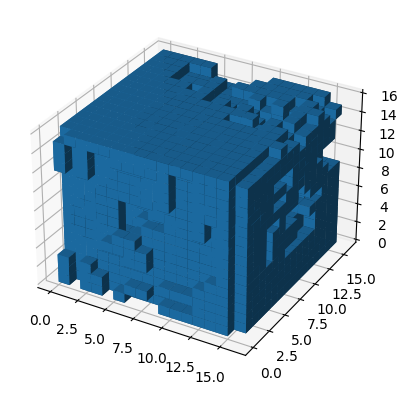

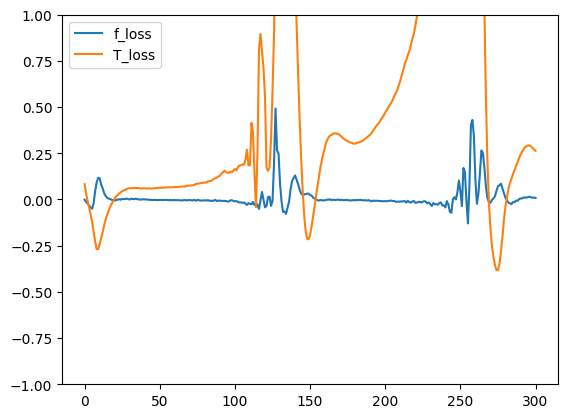

  8%|▊         | 400/5001 [03:05<31:15,  2.45it/s]  

T_loss: 0.4517836272716522;  f_loss: -0.009319454431533813


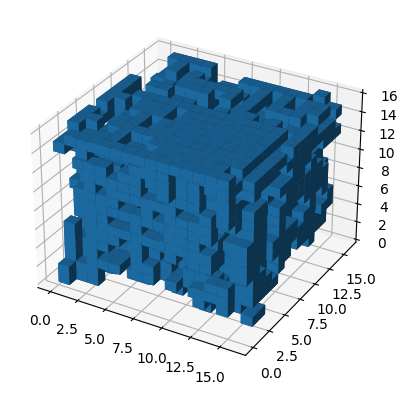

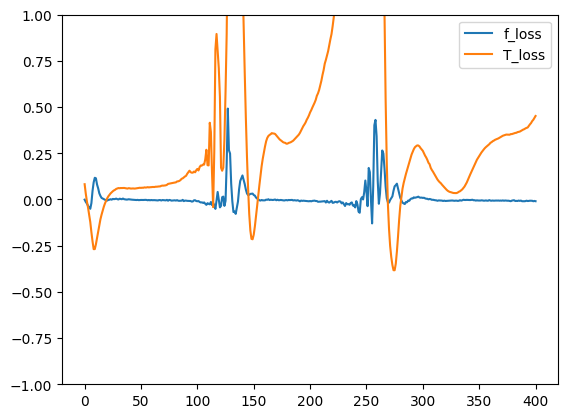

 10%|▉         | 500/5001 [03:51<35:38,  2.10it/s]  

T_loss: -2.650959014892578;  f_loss: 0.3600959777832031


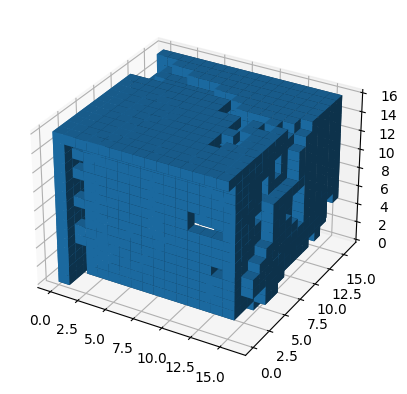

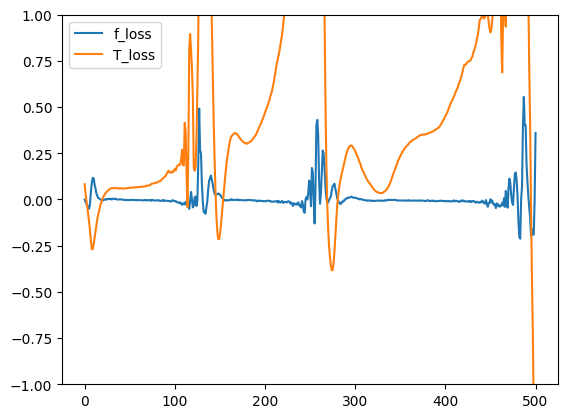

 12%|█▏        | 600/5001 [04:36<35:01,  2.09it/s]  

T_loss: -0.6959063410758972;  f_loss: -0.011083841323852539


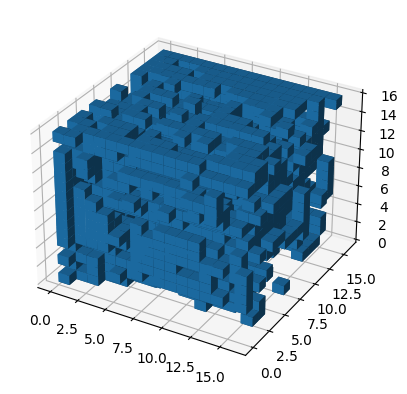

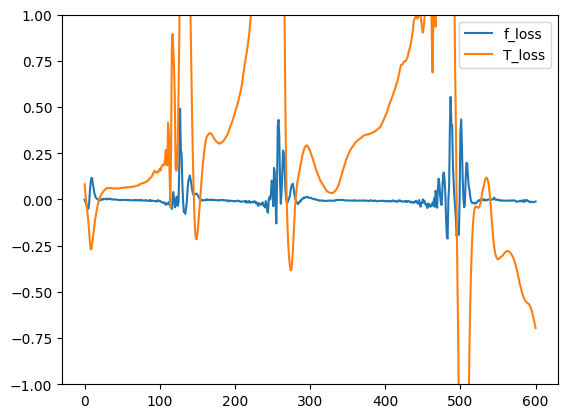

 14%|█▍        | 700/5001 [05:26<28:42,  2.50it/s]  

T_loss: 0.36171770095825195;  f_loss: -0.011149853467941284


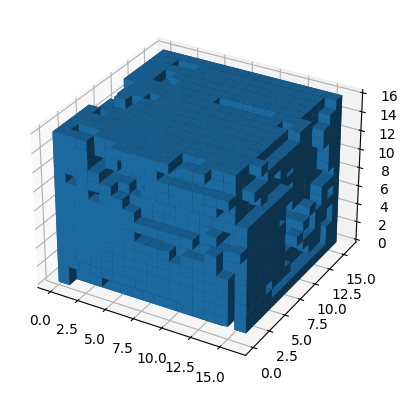

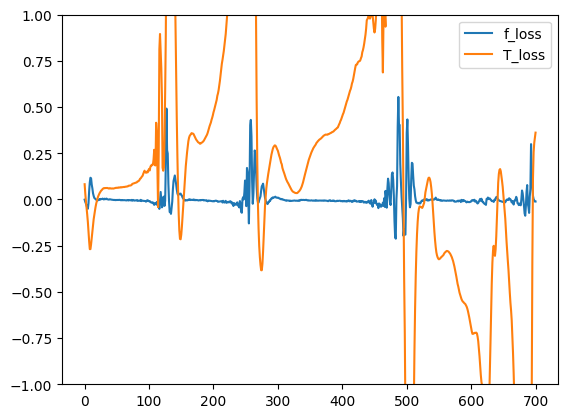

 16%|█▌        | 800/5001 [06:10<27:44,  2.52it/s]

T_loss: 0.31086498498916626;  f_loss: -0.07904312014579773


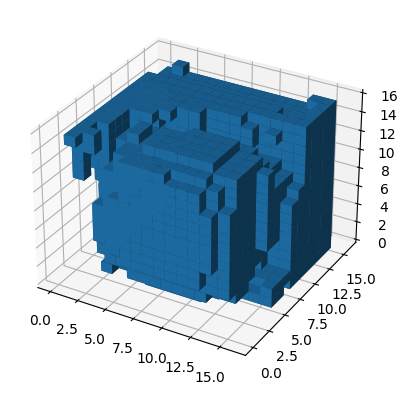

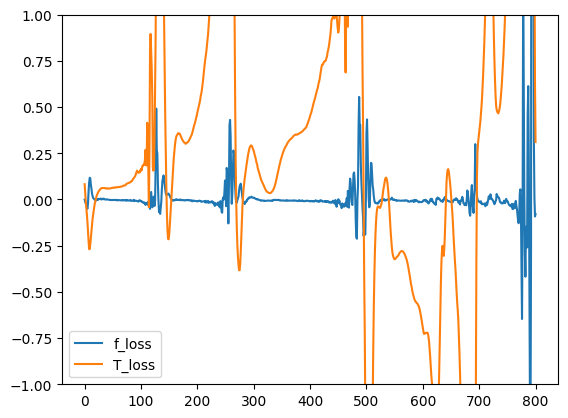

 18%|█▊        | 900/5001 [06:56<20:39,  3.31it/s]

T_loss: -0.1433771699666977;  f_loss: -0.005707144737243652


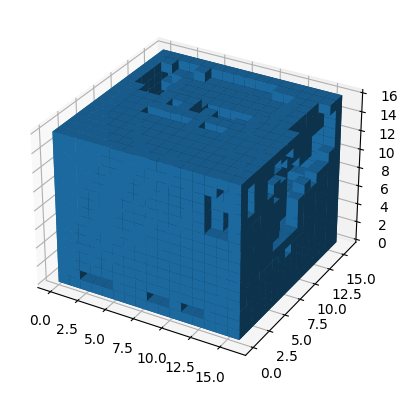

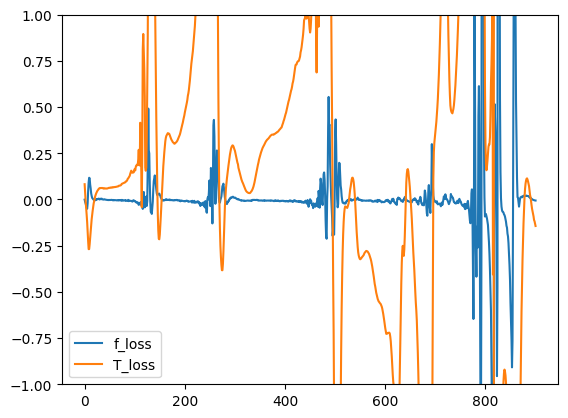

 20%|█▉        | 1000/5001 [07:46<24:24,  2.73it/s]

T_loss: -0.1357269436120987;  f_loss: -0.02103807032108307


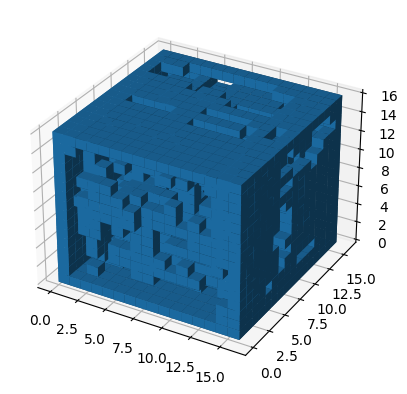

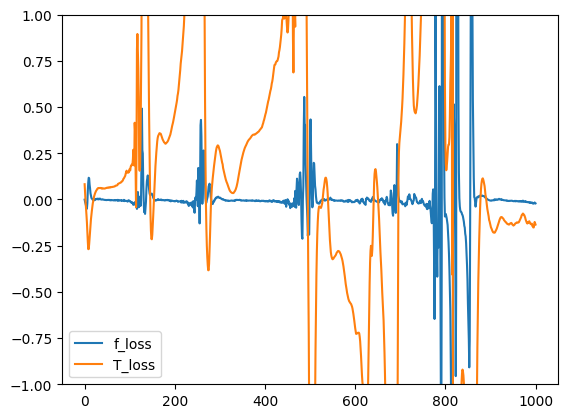

 22%|██▏       | 1100/5001 [08:33<24:02,  2.70it/s]

T_loss: -0.7345607280731201;  f_loss: 0.014626026153564453


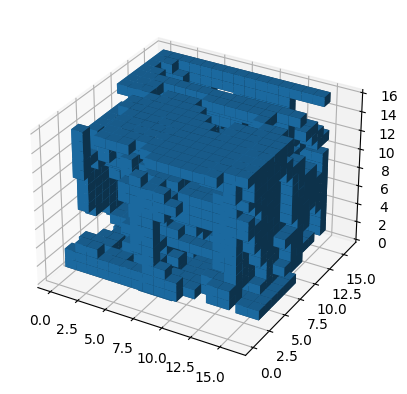

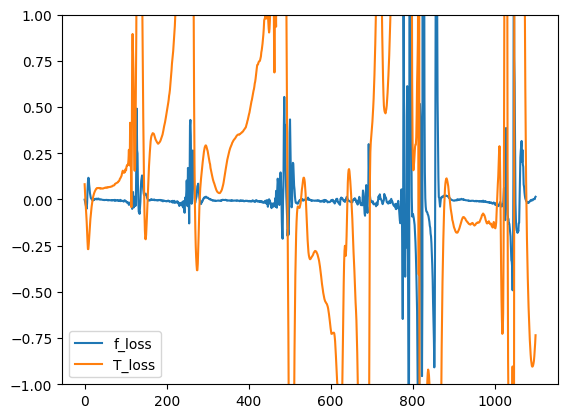

 24%|██▍       | 1200/5001 [09:20<22:49,  2.78it/s]

T_loss: 4.584436416625977;  f_loss: -0.1006617546081543


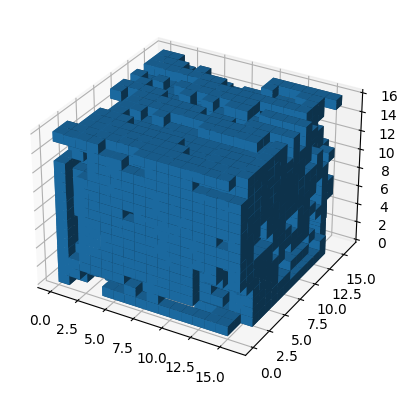

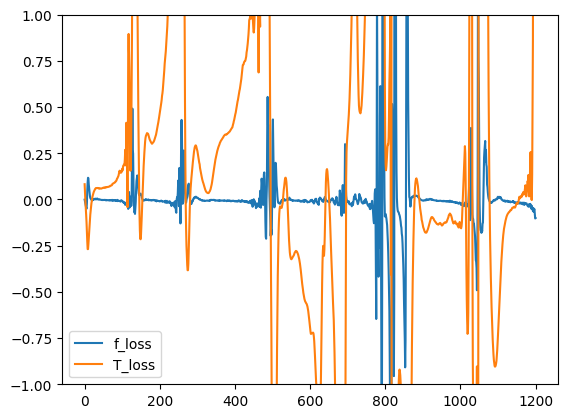

 26%|██▌       | 1300/5001 [10:06<20:54,  2.95it/s]

T_loss: -0.5238046050071716;  f_loss: -0.0042130351066589355


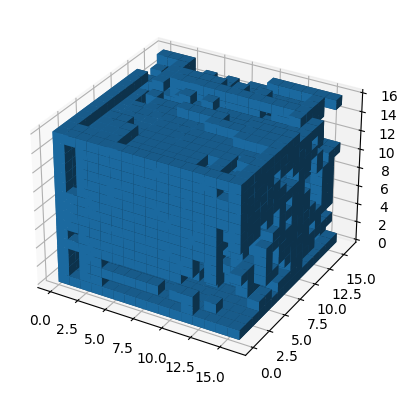

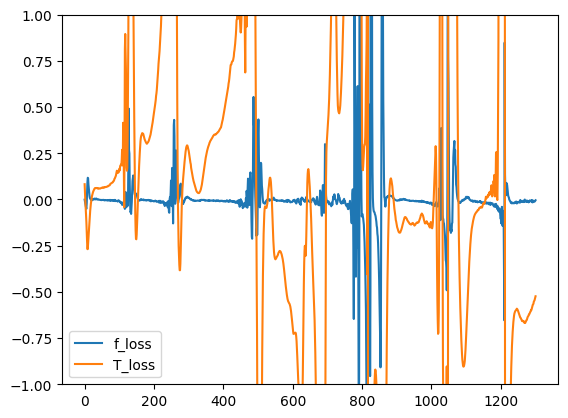

 28%|██▊       | 1400/5001 [10:56<23:59,  2.50it/s]

T_loss: -0.8623248934745789;  f_loss: -0.006684601306915283


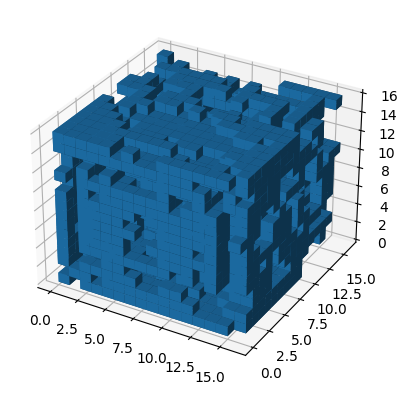

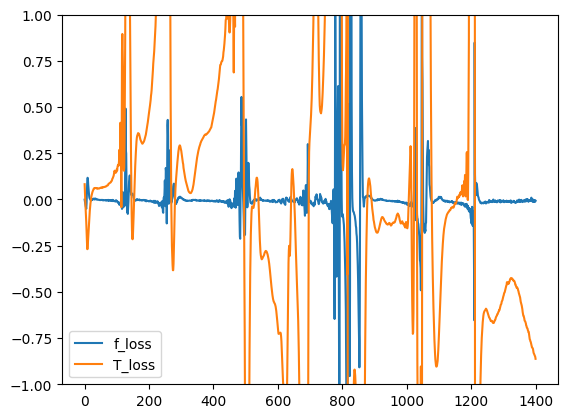

 30%|██▉       | 1500/5001 [11:41<22:16,  2.62it/s]

T_loss: 4.930105209350586;  f_loss: -0.03969287872314453


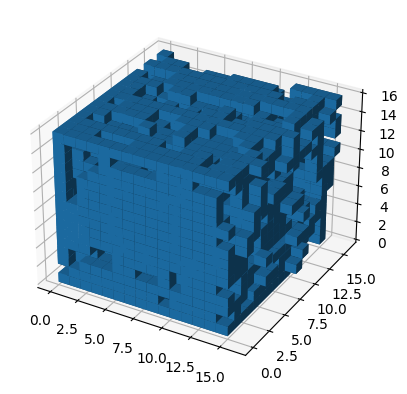

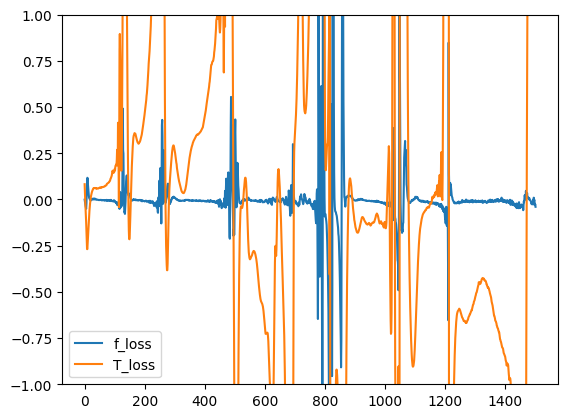

 32%|███▏      | 1600/5001 [12:29<21:07,  2.68it/s]

T_loss: -1.3929686546325684;  f_loss: -0.06587600708007812


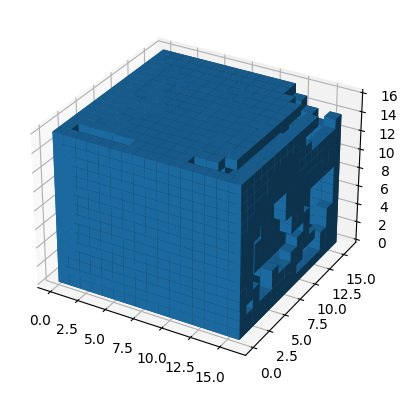

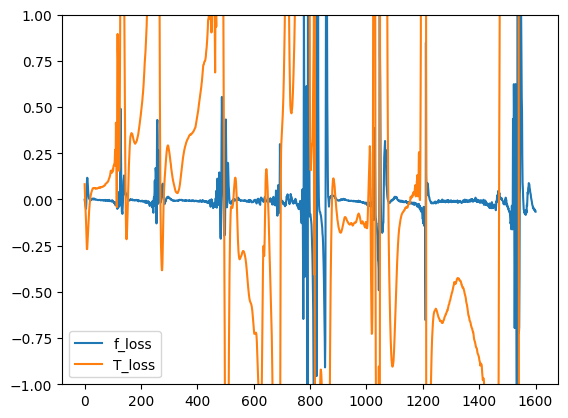

 34%|███▍      | 1700/5001 [13:16<19:52,  2.77it/s]

T_loss: -4.971846580505371;  f_loss: -0.058832645416259766


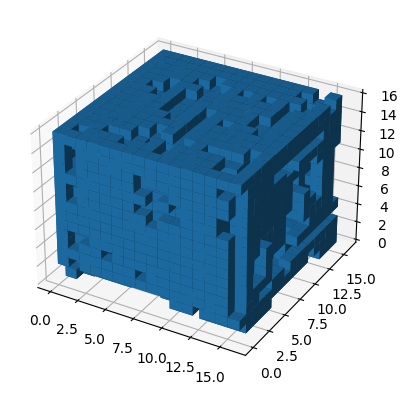

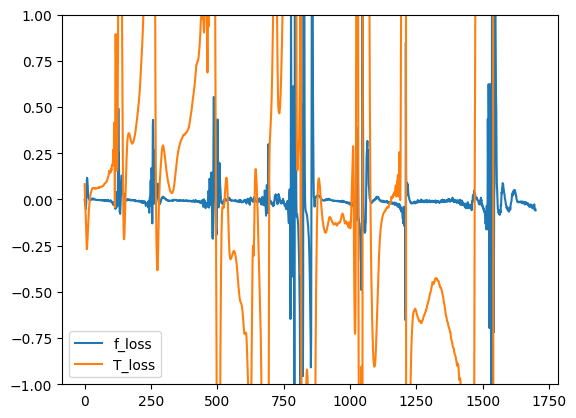

 36%|███▌      | 1800/5001 [14:02<15:55,  3.35it/s]

T_loss: 15.670328140258789;  f_loss: -0.6577816009521484


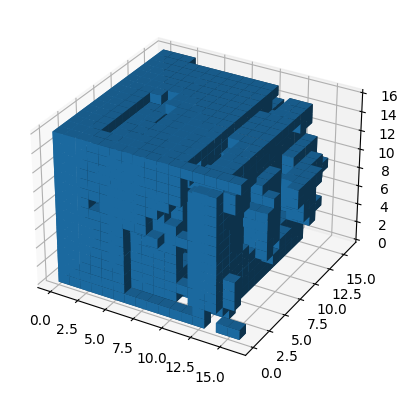

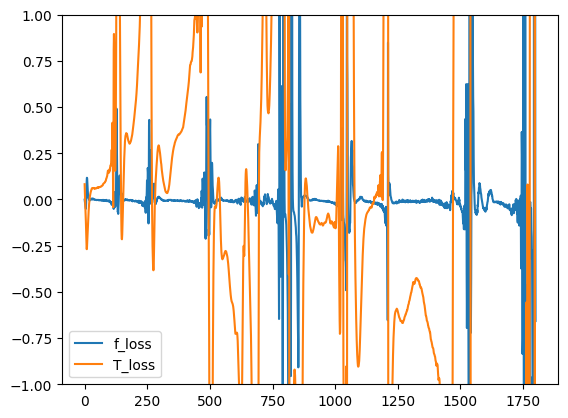

 38%|███▊      | 1900/5001 [14:50<15:53,  3.25it/s]

T_loss: 5.845042705535889;  f_loss: -0.45095157623291016


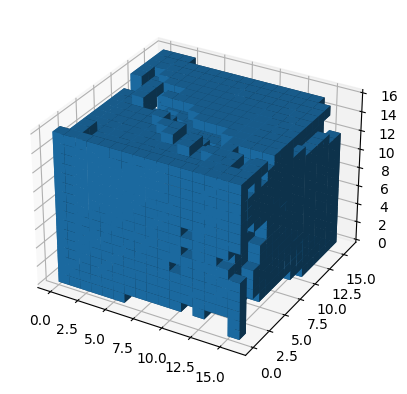

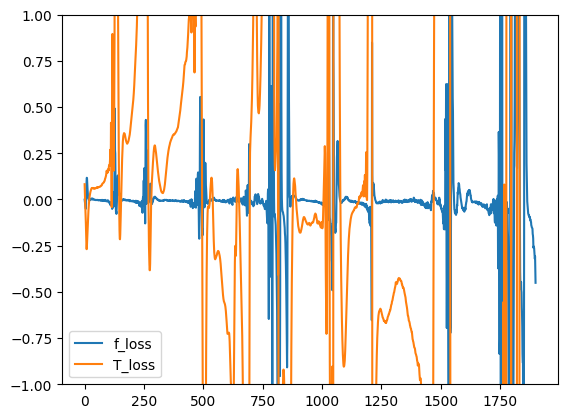

 39%|███▉      | 1961/5001 [15:08<23:28,  2.16it/s]


KeyboardInterrupt: 

In [11]:
test_sample = sample_test().cuda()
plot_img(test_sample[0].cpu())
T_losses = []
f_losses = []

for step in tqdm(range(5001)):
    # clear_output(wait=True)

    # Training T, freezing f
    T.train(True)
    f.eval()
    
    for i in range(5):
        X = sample_train_a().cuda()

        T_X = T(X)
        T_loss = sq_cost(X, T_X).mean() - f(T_X).mean()
        T_opt.zero_grad()
        T_loss.backward()
        T_opt.step()
    
    T_losses.append(T_loss.cpu().detach().numpy())

    # Training f, freezing T
    f.train(True)
    T.eval()

    X = sample_train_a().cuda()
    Y = sample_train_b().cuda()

    with torch.no_grad():
        T_x = T(X)
    
    f_loss = f(T_x).mean() - f(Y).mean()
    f_opt.zero_grad()
    f_loss.backward()
    f_opt.step()

    f_losses.append(f_loss.cpu().detach().numpy())

    if not step % 100:
        print(f"T_loss: {T_loss}; ", end="")
        print(f" f_loss: {f_loss}")
        T_X = torch.clip(T(test_sample)[0].cpu().detach(), min=0, max=1)
        plot_img(T_X)

        plt.plot(np.arange(len(f_losses)), f_losses, label="f_loss")
        plt.plot(np.arange(len(T_losses)), T_losses, label="T_loss")

        plt.ylim(-1, 1)
        plt.legend()
        plt.show()

    # Save OT map every 1000 steps
    if not step % 1000:
        torch.save(T.state_dict, f"weights/OT_{step}.pt")

    gc.collect()
    torch.cuda.empty_cache()

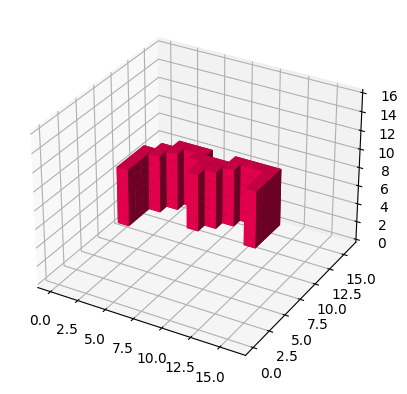

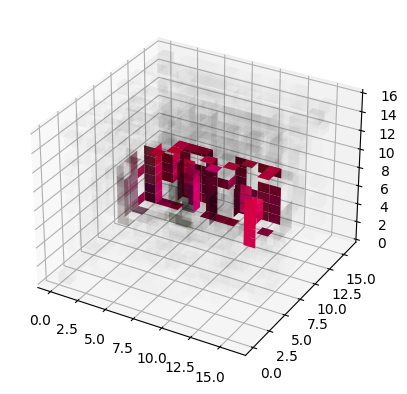

In [ ]:
plot_img(test_sample[2].cpu())

T_X = torch.clip(T(test_sample)[2].cpu().detach(), min=0, max=1)

plot_img(T_X)